### Define paths and animals for the analysis

In [1]:
path = '/media/andrey/My Passport/GIN/Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'
path4results = '/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/results/' #To store transformation matrisies
save_plots_path = '/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/results/plots'
log_file_path = save_plots_path + 'registration_logs.txt'

animals_for_analysis = [51]

### Align FOV's for all recordings

In [2]:
repeat_calc = 1
silent_mode = False

#######################

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize)

from pystackreg import StackReg

# Sobel filter (not used)
#from scipy import ndimage #https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html

meta_data = pd.read_excel(path)

#%% compute transformations matrices between recordings

recordings = meta_data['Number']

animals = animals_for_analysis

#print("Recordings: ", recordings)

#ALIGNMENT ALGORITHM

# log file

f = open(log_file_path, "a")

print("n, i, j, rigid_mean_enh, rigid_mean, affine_mean_enh, affine_mean, best_method ", file=f)

if (silent_mode!=True):
    print(" RMSD's: (rigid, mean_enh) | (rigid, mean) | (affine, mean_enh) | (affine, mean) | best method ")


for animal in animals:
    
    if (silent_mode!=True):
        print("Animal #", str(animal))
    
    
    if not os.path.exists(path4results + 'StackReg/' +
                          str(animal) + '.npy') or repeat_calc == 1:
#    if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage/' +
#                          str(animal) + '.npy') or repeat_calc == 1:
#    if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackReg/' +
#                          str(animal) + '.npy') or repeat_calc == 1:
       
        meta_animal = meta_data[meta_data['Mouse'] == animal]
        recordings = meta_animal['Number']
        
        images_mean = np.zeros((512, 512, np.shape(recordings)[0]))
        images_mean_enh = np.zeros((512, 512, np.shape(recordings)[0]))

        images_quality_check = np.zeros((512, 512, np.shape(recordings)[0]))

        best_tmats = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        best_score = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))
        best_methods =  np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))


        tmats_affine = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_rigid = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_affine_enh = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_rigid_enh = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))

        # load all (enhanced) images
        for idx, recording in enumerate(recordings):
            options = np.load(meta_data['Folder'][recording] + 
                              meta_data['Subfolder'][recording] +
                              str(int(meta_data['Recording idx'][recording])) +
                              '/suite2p/plane0/ops.npy',
                              allow_pickle=True)
        # mean image or mean enhanced image
            images_mean[:, :, idx] = options.item(0)['meanImg']
            images_mean_enh[:, :, idx] = options.item(0)['meanImgE']
            #cut_boarders=50
            #quality check
            images_quality_check[:, :, idx] = options.item(0)['meanImg']


        # loop through every pair and compute the transformation matrix
        
        conditions = [meta_data['Condition'][recording] for recording in recordings]
        
        for idx0 in range(np.shape(images_mean)[2]):
            #if (idx0!=14):
                    #continue
            
            for idx1 in range(idx0, np.shape(images_mean)[2]):
                #if (idx1!=16):
                    #continue
           
                      
                fraction_of_non_zero_pixels = [0.0,0.0,0.0,0.0]
                
### MEAN RIGID and AFFINE

                reference_image = images_mean[:, :, idx0]
                initial_image = images_mean[:, :, idx1]

                #sx = ndimage.sobel(reference_image, axis=0, mode='constant')
                #sy = ndimage.sobel(reference_image, axis=1, mode='constant')
                #reference_image = np.hypot(sx, sy)

                #sx = ndimage.sobel(initial_image, axis=0, mode='constant')
                #sy = ndimage.sobel(initial_image, axis=1, mode='constant')
                #initial_image = np.hypot(sx, sy)

                boarder_cut = 100
                sr = StackReg(StackReg.AFFINE)
                tmats_affine[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                
                image_transformed =  sr.transform(images_quality_check[:, :, idx1], tmats_affine[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] -  image_transformed
                fraction_of_non_zero_pixels[3] = np.count_nonzero(image_transformed[:,:]<0.001)/262144
                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_affine = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 3 (mean affine): ", fraction_of_non_zero_pixels[3]," Score:",rmsd_affine)

                sr = StackReg(StackReg.RIGID_BODY)
                tmats_rigid[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                image_transformed = sr.transform(images_quality_check[:, :, idx1], tmats_rigid[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed
                fraction_of_non_zero_pixels[1] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_rigid = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 1 (mean rigid): ", fraction_of_non_zero_pixels[1], "Score", rmsd_rigid)

                #plt.imshow(image_difference)


### MEAN_ENH RIGID and AFFINE

                reference_image = images_mean_enh[:, :, idx0]
                initial_image = images_mean_enh[:, :, idx1]

                # sx = ndimage.sobel(reference_image, axis=0, mode='constant')
                # sy = ndimage.sobel(reference_image, axis=1, mode='constant')
                # reference_image = np.hypot(sx, sy)

                # sx = ndimage.sobel(initial_image, axis=0, mode='constant')
                # sy = ndimage.sobel(initial_image, axis=1, mode='constant')
                # initial_image = np.hypot(sx, sy)

                boarder_cut = 100
                sr = StackReg(StackReg.AFFINE)
                tmats_affine_enh[idx0, idx1, :, :] = sr.register(reference_image, initial_image)

                image_transformed = sr.transform(images_quality_check[:, :, idx1], tmats_affine_enh[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed  #TODO: delete image quality check! replace it with meanimage 
                fraction_of_non_zero_pixels[2] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_affine_enh = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 2 (mean enh affine): ", fraction_of_non_zero_pixels[2],"Score:", rmsd_affine_enh)

                sr = StackReg(StackReg.RIGID_BODY)
                tmats_rigid_enh[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                image_transformed =  sr.transform(images_quality_check[:, :, idx1], tmats_rigid_enh[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed
                fraction_of_non_zero_pixels[0] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_rigid_enh = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 0 (mean enh rigid): ", fraction_of_non_zero_pixels[0],"Score", rmsd_rigid_enh)

                rmsds=[rmsd_rigid_enh,rmsd_rigid,rmsd_affine_enh,rmsd_affine]
                tmatss=[tmats_rigid_enh[idx0, idx1, :, :],tmats_rigid[idx0, idx1, :, :],tmats_affine_enh[idx0, idx1, :, :],tmats_affine[idx0, idx1, :, :]]
                methods=["rigid_mean_enh", "rigid_mean" ,"affine_mean_enh","affine_mean"]
                #print(tmats_rigid_enh,tmats_rigid,tmats_affine_enh,tmats_affine)
                #print(" ")
                #best_method_idx = rmsds.index(min(rmsds))
                #smaller_fraction_idx = fraction_of_non_zero_pixels.index(min(fraction_of_non_zero_pixels))
                #smaller_fraction_idx = 1
                #print(best_method_idx)
                #print(smaller_fraction_idx)
                
                list_of_methods=np.argsort(rmsds)
                
                best_score[idx1, idx0] = np.sort(rmsds)[0]
                best_score[idx0, idx1] = np.sort(rmsds)[0]
                
                the_best_idx = list_of_methods[0]

                
                if (fraction_of_non_zero_pixels[list_of_methods[0]] > 0.1):
                    print("Warning: alignment with the best method failed. The second best method is applied")
                    the_best_idx = list_of_methods[1]
                    if (fraction_of_non_zero_pixels[list_of_methods[1]] > 0.1):
                        print("Warning: alignment with the second best method failed. The 3rd best method is applied")
                        the_best_idx = list_of_methods[2]
                    
                best_method = methods[the_best_idx]
                best_tmats[idx0, idx1, :, :]=tmatss[the_best_idx]
                best_methods[idx1, idx0]=the_best_idx
                best_methods[idx0, idx1]=the_best_idx
            
                
                best_tmats[idx1, idx0, :, :]=np.linalg.inv(best_tmats[idx0, idx1, :, :])


                if(idx0==idx1):
                    best_method="-,-"
                
                if (silent_mode!=True):
                    print("{0:d}, {1:d},  {2:4.4f}, {3:4.4f}, {4:4.4f}, {5:4.4f}, {6:s}".format(idx0, idx1, rmsd_rigid_enh, rmsd_rigid, rmsd_affine_enh, rmsd_affine, best_method))
                
                print("{0:d}, {1:d},  {2:4.4f}, {3:4.4f}, {4:4.4f}, {5:4.4f}, {6:s}".format(idx0, idx1, rmsd_rigid_enh, rmsd_rigid,
                                                                        rmsd_affine_enh, rmsd_affine, best_method), file=f)

                #print(" " + str(idx0) + "-" + str(idx1) + " " + str(rmsd_rigid_enh) + " " + str(rmsd_rigid) + " " + str(rmsd_affine_enh) + " " +  str(rmsd_affine))
                # plt.imshow(image_difference)

                #plt.savefig(save_plots_path + "StackRegVisualInspection/" + file_title + "_d_reference_m_corrected.png")

                #print(str(idx0) + '-' + str(idx1))
        # save all the transformation matrices
        if not os.path.exists(path4results+'StackReg'):
            os.makedirs(path4results+'StackReg')
        #print(best_tmats)
        np.save(path4results+'StackReg/' + str(animal) + "_best_tmats", best_tmats)
        np.save(path4results+'StackReg/' + str(animal) + "_best_methods", best_methods)
        np.save(path4results+'StackReg/' + str(animal) + "_best_score", best_score)

#        if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage'):
#            os.makedirs('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage')
#        np.save('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage/' + str(animal), tmats)
#        if not os.path.exists(save_plots_path+ 'StackRegAffine'):
#            os.makedirs(save_plots_path + 'StackRegAffine')
#        np.save(save_plots_path+ 'StackRegAffine/' + str(animal), tmats)
f.close()

 RMSD's: (rigid, mean_enh) | (rigid, mean) | (affine, mean_enh) | (affine, mean) | best method 
Animal # 37527
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 1.2401436240957553e-05
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 1.2402128958731363e-05
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 1.240585700392221e-05
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0 Score 1.2409648047438067e-05
0, 0,  0.0000, 0.0000, 0.0000, 0.0000, -,-
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 56.55444156772641
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 56.97586948674832
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 56.65574404369754
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0 Score 57.034153598758614
0, 1,  57.0342, 56.9759, 56.6557, 56.5544, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.001953125  Score: 63.68298375355367
Fraction of non-zero pixels in 1 (mean rigid):  0.

Fraction of non-zero pixels in 2 (mean enh affine):  0.012912750244140625 Score: 336.7091345205876
Fraction of non-zero pixels in 0 (mean enh rigid):  0.02292633056640625 Score 343.90670253890494
0, 18,  343.9067, 337.1361, 336.7091, 336.0054, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.047794342041015625  Score: 378.2298236817599
Fraction of non-zero pixels in 1 (mean rigid):  0.05127716064453125 Score 382.7646909522532
Fraction of non-zero pixels in 2 (mean enh affine):  0.00174713134765625 Score: 449.0884811272072
Fraction of non-zero pixels in 0 (mean enh rigid):  0.029590606689453125 Score 471.43891340752685
0, 19,  471.4389, 382.7647, 449.0885, 378.2298, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.042819976806640625  Score: 429.7402417841638
Fraction of non-zero pixels in 1 (mean rigid):  0.0512847900390625 Score 412.5569357890424
Fraction of non-zero pixels in 2 (mean enh affine):  0.042156219482421875 Score: 407.0271542791977
Fraction of no

Fraction of non-zero pixels in 2 (mean enh affine):  0.001953125 Score: 51.23820730474139
Fraction of non-zero pixels in 0 (mean enh rigid):  0.001953125 Score 52.89618905877888
1, 3,  52.8962, 53.1905, 51.2382, 51.4453, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.01253509521484375  Score: 151.8112268125583
Fraction of non-zero pixels in 1 (mean rigid):  0.015888214111328125 Score 155.25956879528917
Fraction of non-zero pixels in 2 (mean enh affine):  0.00640869140625 Score: 157.88650700340995
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0146484375 Score 155.80927254575653
1, 4,  155.8093, 155.2596, 157.8865, 151.8112, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.013912200927734375  Score: 147.47334681276797
Fraction of non-zero pixels in 1 (mean rigid):  0.01764678955078125 Score 151.404833157979
Fraction of non-zero pixels in 2 (mean enh affine):  0.010250091552734375 Score: 149.56511673941742
Fraction of non-zero pixels in 0 (mean en

Fraction of non-zero pixels in 0 (mean enh rigid):  0.05707550048828125 Score 422.9382758403293
1, 21,  422.9383, 487.2784, 423.1554, 485.2466, rigid_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.07671737670898438  Score: 448.72805503702597
Fraction of non-zero pixels in 1 (mean rigid):  0.0489044189453125 Score 475.18879115371203
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 470.1415313828796
Fraction of non-zero pixels in 0 (mean enh rigid):  0.01750946044921875 Score 482.07633065022287
1, 22,  482.0763, 475.1888, 470.1415, 448.7281, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.0156402587890625  Score: 430.46633112522414
Fraction of non-zero pixels in 1 (mean rigid):  0.020763397216796875 Score 446.00857735249315
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 441.571679545594
Fraction of non-zero pixels in 0 (mean enh rigid):  0.019439697265625 Score 452.63972527728896
1, 23,  452.6397, 446.0086, 441.5717, 430.4663, a

KeyboardInterrupt: 

### Install package for image comparison (similarity index)

In [79]:
!conda install -c conda-forge imagehash --yes
#!pip install ImageHash # as alternative if anaconda is not installed

Solving environment: done

## Package Plan ##

  environment location: /home/andrey/anaconda3

  added / updated specs:
    - imagehash


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imagehash-4.2.0            |     pyhd8ed1ab_0         292 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         292 KB

The following NEW packages will be INSTALLED:

  imagehash          conda-forge/noarch::imagehash-4.2.0-pyhd8ed1ab_0



imagehash-4.2.0      | 292 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


Animal # 51


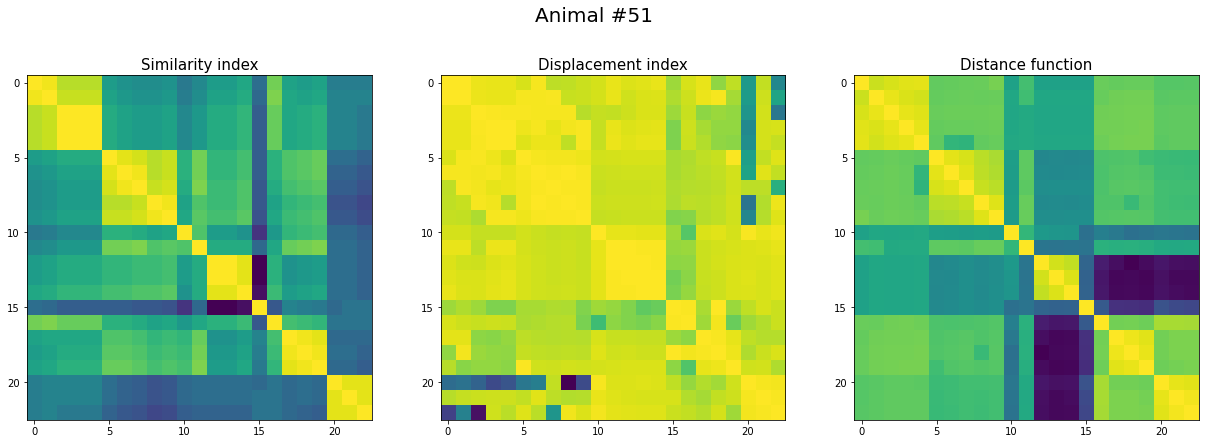

In [33]:
from PIL import Image
import imagehash


for animal in animals:
    print("Animal #", str(animal))
    
    meta_animal = meta_data[meta_data['Mouse'] == animal]
    recordings = meta_animal['Number']
    index_similarity = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))
    
    cut = 100
    
    images_mean = np.zeros((512, 512, np.shape(recordings)[0]))
    images_mean_enh = np.zeros((512, 512, np.shape(recordings)[0]))

        # load all (enhanced) images
    for idx, recording in enumerate(recordings):
        options = np.load(meta_data['Folder'][recording] +
                              meta_data['Subfolder'][recording] +
                              str(int(meta_data['Recording idx'][recording])) +
                              '/suite2p/plane0/ops.npy',
                              allow_pickle=True)
        # mean image or mean enhanced image
        images_mean[:, :, idx] = options.item(0)['meanImg']
        images_mean_enh[:, :, idx] = options.item(0)['meanImgE']


    for idx0 in range(np.shape(images_mean)[2]):            
        for idx1 in range(idx0, np.shape(images_mean)[2]):
            hash1=imagehash.average_hash(Image.fromarray(images_mean[cut:-cut, cut:-cut, idx0]))
            otherhash=imagehash.average_hash(Image.fromarray(images_mean[cut:-cut, cut:-cut, idx1]))
            index_similarity[idx0,idx1] = (hash1 - otherhash)
            index_similarity[idx1,idx0] = (hash1 - otherhash)
    index_similarity = (np.max(index_similarity)-index_similarity)/np.max(index_similarity)    
    
    best_tmats = np.load(path4results+'StackReg/' + str(animal) + "_best_tmats.npy")
    best_score = np.load(path4results+'StackReg/' + str(animal) + "_best_score.npy")
    
    metric_best_tmats = np.abs(best_tmats)
    metric_best_tmats = metric_best_tmats.sum(axis=(2,3))
    metric_best_tmats = np.max(metric_best_tmats) - metric_best_tmats
    
    metric_best_score = (np.max(best_score)-best_score)/np.max(best_score)
    #plt.xticks(np.arange(0, np.shape(images_mean)[2], 1));
    #plt.yticks(np.arange(0, np.shape(images_mean)[2], 1));
    
    fig, ax = plt.subplots(1,3, figsize=(21, 7))
    
    ax[0].imshow(index_similarity)
    ax[0].set_title("Similarity index", fontsize = 15)
    ax[1].imshow(metric_best_tmats)
    ax[1].set_title("Displacement index", fontsize = 15)
    ax[2].imshow(metric_best_score)
    ax[2].set_title("Distance function", fontsize = 15)
    fig.suptitle('Animal #' + str(animal), fontsize = 20)
    
    plt.savefig("./FOV_Validation_" + str(animal) + ".png")

### Plot all corrected FOV's for comparison (optional)

**The running takes considerable amount of time!**

In [23]:
for animal in animals:

    tmats_loaded = np.load(path4results + 'StackReg/' + str(animal) + "_best_tmats" + '.npy')
    meta_animal = meta_data[meta_data['Mouse'] == animal]
    recordings = meta_animal['Number']
    images = np.zeros((512, 512, np.shape(meta_animal)[0]))
    
    images_mean = np.zeros((512, 512, np.shape(recordings)[0]))
    images_mean_enh = np.zeros((512, 512, np.shape(recordings)[0])) 
    
        # load all (enhanced) images
    for idx, recording in enumerate(recordings):
        options = np.load(meta_data['Folder'][recording] + 
                              meta_data['Subfolder'][recording] +
                              str(int(meta_data['Recording idx'][recording])) +
                              '/suite2p/plane0/ops.npy',
                              allow_pickle=True)
        # mean image or mean enhanced image
        images_mean[:, :, idx] = options.item(0)['meanImg']
        images_mean_enh[:, :, idx] = options.item(0)['meanImgE']
            #cut_boarders=50
            #quality check
        #images_quality_check[:, :, idx] = options.item(0)['meanImg']


        # loop through every pair and compute the transformation matrix
        
    conditions = [meta_data['Condition'][recording] for recording in recordings]
    recording_idx = [meta_data['Recording idx'][recording] for recording in recordings]

    for idx0 in range(np.shape(images_mean)[2]):
        #if (idx0!=14):
            #continue
        for idx1 in range(idx0, np.shape(images_mean)[2]):
            #if (idx1!=16):
                #continue
           
            reference_image = images_mean_enh[:, :, idx0]
            initial_image = images_mean_enh[:, :, idx1] 
    
            if not os.path.exists(save_plots_path + 'StackRegVisualInspection/'):
                os.makedirs(save_plots_path + 'StackRegVisualInspection/')
            if not os.path.exists(save_plots_path + 'StackRegVisualInspection/'  + str(animal) + '/'):
                os.makedirs(save_plots_path + 'StackRegVisualInspection/'  + str(animal) + '/')

 
            plt.imshow(reference_image)

                # image_title = meta_data['Subfolder'][recording][:-1] + str(meta_data['Recording idx'][recording]) + "\n" + "_condition_" + \
                #    meta_data['Condition'][recording]
                # plt.title(image_title)
                #file_title = meta_data['Subfolder'][recording][:-1] + str(
                 #   meta_data['Recording idx'][recording]) + "_condition_" + \
                 #            meta_data['Condition'][recording] + "_" + str(idx0) + "_" + str(idx1)
        
            file_title = str(str(idx0) + '_' + str(idx1) + '_' + conditions[idx0]) + '_' + str(recording_idx[idx0]) + '_' + str(conditions[idx1]) + "_" + str(recording_idx[idx1]) 
            print(file_title)
                
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_b_reference.png")
                #sx = ndimage.sobel(images[:, :, idx1], axis=0, mode='constant')
                #sy = ndimage.sobel(images[:, :, idx1], axis=1, mode='constant')
                #sob = np.hypot(sx, sy)
                #plt.imshow(sob)
            plt.imshow(initial_image)
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_a_initial.png")
                #grad = np.gradient(images[:, :, idx1])

                #print(images[50:55, 50:55, idx1].shape)
                #grad = np.gradient(images[50:55, 50:55, idx1])
                #print(images[50:55, 50:55, idx1])
                #print(" ")
                #print(grad)

                #image_inversed = sr.transform(reference_image, best_tmats[idx1, idx0, :, :])
                #plt.imshow(image_inversed)
                #plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_1_inversed.png")

                #sx = ndimage.sobel(images[:, :, idx1], axis=0, mode='constant')
                #sy = ndimage.sobel(images[:, :, idx1], axis=1, mode='constant')
                #sob = np.hypot(sx, sy)
                #plt.imshow(images[:, :, idx1])
                #plt.savefig(save_plots_path + "StackRegVisualInspection/" + file_title + "_sobel.png")
            image_corrected = sr.transform(initial_image,  tmats_loaded[idx0, idx1, :, :])
            plt.imshow(image_corrected)
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_c_corrected.png")
                #image_difference = images_quality_check[:, :, idx0] - sr.transform(images_quality_check[:, :, idx1], best_tmats[idx0, idx1, :, :])
                #image_difference = reference_image - image_corrected
                #plt.imshow(image_difference)
                #plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_d_reference_m_corrected.png")



IndentationError: unexpected indent (<ipython-input-23-76c15922c7fc>, line 13)

In [9]:
###TODO Seaborn Scatterplot heatmap could be a nice option for plotting

In [ ]:

# ROI adjustment check for all recordings

from matplotlib import colors
Amap = colors.ListedColormap(['white','tab:blue', 'tab:red','purple'])
 
if not os.path.exists(save_plots_path + 'ROIAdjustmentCheck/'):
    os.makedirs(save_plots_path + 'ROIAdjustmentCheck/')
   
for animal in animals:
    if not os.path.exists(save_plots_path + 'ROIAdjustmentCheck/' + str(animal) + "/"):
        os.makedirs(save_plots_path + 'ROIAdjustmentCheck/' + str(animal) + "/")  
    
    tmats_loaded = np.load(path4results + 'StackReg/' + str(animal) + "_best_tmats" + '.npy')
    meta_animal = meta_data[meta_data['Mouse'] == animal]
    recordings = meta_animal['Number'] #,'blue', 'green','cyan'])

    images = np.zeros((512, 512, np.shape(meta_animal)[0]))

    for idx, recording in enumerate(recordings):
        stats = np.load(meta_data['Folder'][recording] +
                        str(meta_data['Subfolder'][recording]) +
                        #str(int(meta_data['Recording idx'][recording])) +
                        '/suite2p/plane0/stat.npy',
                        allow_pickle=True)
        iscell = np.load(meta_data['Folder'][recording] +
                         str(meta_data['Subfolder'][recording]) +
                         #str(int(meta_data['Recording idx'][recording])) +
                         '/suite2p/plane0/iscell.npy',
                         allow_pickle=True)
        stats = stats[iscell[:, 0].astype(bool)]

        for stats_neuron in stats:
                images[stats_neuron['ypix'], stats_neuron['xpix'], idx] += 1
        images[:,:,idx][images[:,:,idx]>1] = 1
        
    roi_corresp = np.zeros((512, 512))
    
    #for idx0 in range(np.shape(images)[2]):
        #for idx1 in range(idx0, np.shape(images)[2]):
    for idx0, recording0 in enumerate(recordings):
        for idx1, recording1 in enumerate(recordings):
           # roi_corresp = images[:,:,idx0] + 2*images[:,:,idx1]
            roi_corresp = images[:,:,idx0] + 2*sr.transform(images[:, :, idx1], tmats_loaded[idx0, idx1, :, :])
            file_title = str(idx0) + "_" + str(idx1) + "_" + meta_data['Condition'][recording0] + "_" + meta_data['Condition'][recording1]
            print(file_title)
            plt.imshow(roi_corresp[:,:],cmap=Amap) #'tab10'
            #plt.annotate('blue - reference / green - corrected / cyan - intersection', xy=(0, 0), xytext=(.8, 0), fontsize=12)
            plt.savefig(save_plots_path + "ROIAdjustmentCheck/" + str(animal) + '/' + file_title + "_ROI_correspondence.png")
            #plt.show()
